In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.layers import Dense, Activation,Flatten
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
lemmatizer = WordNetLemmatizer()

#set random seed for the session and also for tensorflow that runs in background for keras
set_random_seed(123)
random.seed(123)


In [31]:
train= pd.read_csv("./drive/My Drive/sentiment-analysis/train.tsv", sep="\t")
test = pd.read_csv("./drive/My Drive/sentiment-analysis/test.tsv", sep="\t")

train.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [32]:
train['Phrase'][100]

'would have a hard time sitting through this one .'

In [0]:
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [34]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [35]:
#cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))


100%|██████████| 66292/66292 [00:30<00:00, 2203.45it/s]

156060
66292


In [36]:
train_sentences[100]

['would', 'have', 'a', 'hard', 'time', 'sitting', 'through', 'this', 'one']

In [0]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [38]:
y_target

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [0]:
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [40]:
#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 462306.14it/s]

13731
48


In [41]:
for x in tqdm(X_train[1:10]):
  print(x)


100%|██████████| 9/9 [00:00<00:00, 4154.15it/s]

['all', 'the', 'stomach', 'turning', 'violence', 'colorful', 'new', 'york', 'gang', 'lore', 'and', 'other', 'hallmark', 'of', 'his', 'personal', 'cinema', 'painted', 'on', 'their', 'largest', 'ever', 'historical', 'canvas']
['durable', 'best']
['exciting', 'new', 'filmmaker']
['is', 'supposed', 'to', 'be', 'growing']
['the', 'emperor', 's', 'club']
['pinned', 'to', 'it', 'huckster', 'lapel', 'while', 'a', 'yellow', 'streak', 'a', 'mile', 'wide', 'decorates', 'it', 'back']
['leaf', 'a', 'bad', 'taste', 'in', 'your', 'mouth', 'and', 'question']
['a', 'calculating', 'fiend', 'or', 'just']
['a', 'savage', 'john', 'water', 'like', 'humor']


In [42]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [43]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

#Model using Keras LSTM
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 300)           4119300   
_________________________________________________________________
lstm_3 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 4,395,361
Trainable params: 4,395,361
Non-trainable params: 0
_________________________________________________________________


In [44]:
!rm -R ./logs/ # rf

rm: cannot remove './logs/': No such file or directory


In [45]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=4, batch_size=256, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/4
124848/124848 [==============================] - 467s 4ms/step - loss: 1.0351 - acc: 0.5841 - val_loss: 0.8479 - val_acc: 0.6497
Epoch 2/4
124848/124848 [==============================] - 574s 5ms/step - loss: 0.8173 - acc: 0.6665 - val_loss: 0.8101 - val_acc: 0.6679
Epoch 3/4
124848/124848 [==============================] - 567s 5ms/step - loss: 0.7459 - acc: 0.6881 - val_loss: 0.8077 - val_acc: 0.6690
Epoch 4/4
124848/124848 [==============================] - 470s 4ms/step - loss: 0.7008 - acc: 0.7064 - val_loss: 0.8368 - val_acc: 0.6698


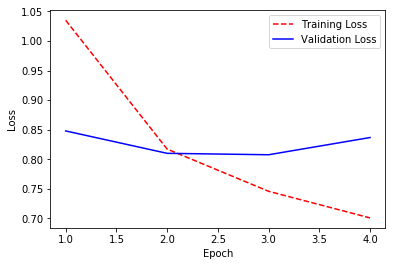

In [49]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [53]:

# What is the final loss and accuracy on our validation data?
valid_loss, valid_acc = model.evaluate_generator(valid_data_gen, steps=nb_valid_steps)
print("Final validation accuracy: {valid_acc*100:.2f}%")

NameError: ignored